## Машинное обучение 1, ПМИ ФКН ВШЭ

## Семинар 1

## Работа с табличными данными

В машинном обучении, как правило, всё сводится к анализу табличных данных. Начинать мы можем с большого количества сложных таблиц, изображений, текстов или ещё чего-то непростого, но в итоге всё это обычно сводится к одной таблице, где каждый объект описывается набором признаков. Поэтому важно уметь работать с таблицами.

А ещё есть некоторые исследования, показывающие, что в решении задачи интеллектуального анализа данных обычно 20% времени уходит на построение моделей и прочую интересную работу, связанную с тем, что рассказывается у нас на лекциях, а 80% времени специалисты тратят на подготовку и обработку данных. Сюда входит формирование признаков, устранение выбросов и пропусков и т.д. И это тоже, по сути дела, манипуляции с таблицами.

Вывод: важно уметь работать с табличными данными. В Python для этого есть библиотека `polars`, которую мы и будем сегодня изучать.

### Зачем нужен polars, когда есть pandas??

Эта версия семинара предполагает, что вы уже являетесь уверенным пользователем `pandas` и знакомы с датафреймами, как они устроены и как ими манипулировать. Библиотека `polars` основана на тех же концептах.

Главные достоинства, которые чуть позже продемонстрируем:
- он написан на Rust, поэтому почти все операции в нём выполняются значительно быстрее, есть распараллеливание из коробки, автоматическая оптимизация запросов и пр
- он позволяет работать с данными, которые не помещаются в оперативку, с этим поможет `pl.LazyFrame` и streaming
- конечно же имеются дополнительные функции, которых в `pandas` нет, но очень хочется, например агрегации с расширяющимся окном, произвольные оконные функции и прочее, для этого есть крайне гибкая штука `pl.Expr`

Подробнее можете прочитать на [любом](https://habr.com/ru/articles/710240/) [ресурсе](https://realpython.com/polars-python/), [посвящённом](https://blog.jetbrains.com/pycharm/2024/07/polars-vs-pandas/) [`polars`](https://habr.com/ru/companies/spectr/articles/738766/)

Имейте в виду, что синтаксис `polars` отличается от привычного нампаевского и больше похож на pyspark. У этого есть как плюсы, так и минусы.

Скорее всего все ваши самые извращённые фантазии уже как-то реализованы в `polars`, поэтому читайте внимательно. Ну и конечно гуглить не запрещено, но желательно прикладывать источник

Материалы:
1. [Getting started](https://docs.pola.rs/user-guide/getting-started/#reading-writing) из официального руководства
2. [Документация](https://docs.pola.rs/api/python/stable/reference/index.html) со всем необходимым
3. [Модификация для Data Science](https://polars-ds-extension.readthedocs.io/en/latest/index.html), вам скорее всего не понадобится в данном задании, но имейте в виду

Чаще всего название библиотеки при импорте сокращают до `pl`:

In [ ]:
!pip install -qU fastexcel polars xlsx2csv

In [3]:
import polars as pl
import pandas as pd
import numpy as np

Ноутбук довольно сильно переделан, по сравнению с пандасовским, поскольку фундаментальные вещи в `polars` и `pandas` отличаются. Там, где это возможно, воспроизведено ровно то же самое. В чем-то библиотеки похожи, но во многом различны. Как обычно, выбор библиотеки это прежде всего дело вкуса

### Распределение студентов по элективам

Разумно тренироваться на реальных сложных данных. А что может быть более сложным, чем данные, сгенерированные студентами?

Сегодня мы будем работать с анкетами студентов ПМИ 2017 и 2018 годов набора о том, на какие курсы по выбору они хотят попасть. Данные были анонимизированы: ФИО захешированы с солью, к рейтингам добавлен случайный шум.

*Вопрос: как можно деанонимизировать данные после манипуляций, которые мы проделали? А как бы вы предложили провести анонимизацию?*

У нас есть 2 таблицы (для 3 и 4 курса):

    – 'Timestamp': время получения ответов
    – 'ID': ID студента (может повторяться, если студент больше одного раза заполнял анкету)
    – 'Рейтинг': Кредитно-рейтинговая сумма студента (грубо говоря, сумма оценок студента по всем его дисциплинам с весами — чем дольша шла дисциплина, тем больше вес; подробности тут: https://www.hse.ru/studyspravka/rate/)
    – 'Группа (в формате 182)': Номер группы
    – 'МИ?': 1, если студент распределился на специализацию МИ, или NaN в противном случае (признак важен, поскольку студенты МИ берут осенью два курса по выбору, а студенты остальных специализаций только один)
    – 'Осенний курс по выбору, приоритет 1'
    – 'Осенний курс по выбору, приоритет 2'
    – 'Осенний курс по выбору, приоритет 3'
    – 'Весенний курс по выбору, приоритет 1'
    – 'Весенний курс по выбору, приоритет 2'
    – 'Весенний курс по выбору, приоритет 3'
    – 'Вы заполняете анкету в первый раз?': "Да" или "Нет"
   
Дополнительные столбцы для 4ого курса:
    
    – 'Группа (в формате 173)': Номер группы
    – 'blended-курс': Выбор blended-курса (кол-во мест неограничено)

Загрузим данные (обратите внимание, что мы уже не так легко читаем xlsx-файлы, но для этого достаточно поставить еще одну библиотеку):

In [4]:
!wget  -O 'data_3_course.xlsx' -q 'https://www.dropbox.com/s/ysxs5srafoyxknb/_data_3_course.xlsx?dl=1'
!wget  -O 'data_4_course.xlsx' -q 'https://www.dropbox.com/s/hfg2mzmvcivtxqk/_data_4_course.xlsx?dl=1'

In [5]:
# data3 = pd.read_excel('data_3_course.xlsx') в pandas аналогично

data3 = pl.read_excel('data_3_course.xlsx', engine="xlsx2csv")
data4 = pl.read_excel('data_4_course.xlsx', engine="xlsx2csv")

Посмотрим размер таблицы:

In [6]:
data3.shape # 1 в 1, как в pandas

(223, 12)

Для начала будем работать с одной таблицей для 3 курса. Теперь данные хранятся в переменной ```data3```, которая имеет тип [`pl.DataFrame`](https://docs.pola.rs/py-polars/html/reference/dataframe/index.html). Важно - в `polars` существует его злой брат-близнец [`pl.LazyFrame`](https://docs.pola.rs/py-polars/html/reference/lazyframe/index.html) со своими приколами, о которых позже:

In [7]:
type(data3)

polars.dataframe.frame.DataFrame

`pl.DataFrame` можно создать и вручную, но делается это чуть хитрее, нежели в `pandas`:

In [8]:
# версия в pandas

df_pd = pd.DataFrame(
    {"AAA": [4, 5, 6, 7], "BBB": [10, 20, 30, 40], "CCC": [100, 50, "E", -50]}
)

df_pd

,AAA,BBB,CCC
0,4,10,100
1,5,20,50
2,6,30,E
3,7,40,-50


In [9]:
# версия в polars

df_pl = pl.from_dict(
    {"AAA": [4, 5, 6, 7], "BBB": [10, 20, 30, 40], "CCC": [100, 50, "E", -50]},
    # обратите внимание, что polars будет ругаться, если в колонке неодинаковые типы
    strict=False,
)

df_pl

AAA,BBB,CCC
i64,i64,str
4,10,"""100"""
5,20,"""50"""
6,30,"""E"""
7,40,"""-50"""


При острой необходимости можно легко сконвертировать датафрейм из пандаса в поларс и обратно. Может быть полезно, поскольку разные API, библиотеки и, в конце концов, люди могут принимать один формат, но не принимать другой

In [10]:
df_pl.to_pandas()

,AAA,BBB,CCC
0,4,10,100
1,5,20,50
2,6,30,E
3,7,40,-50


DataFrame можно частично отобразить в jupyter-ноутбуке с помощью методов ```head```(первые строки) и ```sample```(случайные строки):

In [11]:
data3.head(2) # аналогично pandas

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…","""704,0""",181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…","""646,0""",181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет"""


In [12]:
data3.sample(2) # аналогично pandas

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-18 20:34:07""","""fc2c60b8004aa91bc272df84628621…","""642,0""",183,null,"""Язык SQL""","""Сбор и обработка данных с помо…","""Statistical Learning Theory""","""Системы баз данных""","""Машинное обучение 2""","""Анализ данных в бизнесе""","""Нет"""
"""2020-05-17 16:39:53""","""f8c83b338162bb41af2851b5e62f84…","""546,0""",185,null,"""Теория баз данных""","""Язык SQL""","""Безопасность компьютерных сист…","""Промышленное программирование …","""Компьютерные сети""","""Дискретная оптимизация""","""Да"""


Можно немного залезть во внутренности Jupyter, чтобы отобразить сразу несколько таблиц:

In [13]:
display(data3.sample(2)), display(data3.sample(2))

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-18 17:16:47""","""701078e1e897399f675e96bdda5fb1…","""635,0""",188,1,"""Сбор и обработка данных с помо…","""Принятие решений в условиях ри…","""Теория баз данных""","""Промышленное программирование …","""Машинное обучение 2""","""Анализ данных в бизнесе""","""Да"""
"""2020-05-18 11:13:13""","""b8d4c538f6b47a1a692bec6c2f2915…","""688,0""",183,null,"""Безопасность компьютерных сист…","""Высокопроизводительные вычисле…","""Язык SQL""","""Промышленное программирование …","""Компьютерные сети""","""Системы баз данных""","""Да"""


Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-17 01:48:02""","""c97ab5cabace9f00673cc8384771aa…","""627,0""",185,null,"""Безопасность компьютерных сист…","""Теория баз данных""","""Язык SQL""","""Компьютерные сети""","""Промышленное программирование …","""Машинное обучение 2""","""Да"""
"""2020-05-15 03:12:41""","""30f3653fc176d54e89ac3179c455c6…","""624,0""",185,null,"""Безопасность компьютерных сист…","""Матричные вычисления""","""Моделирование временных рядов""","""Дискретная оптимизация""","""Машинное обучение 2""","""Численные методы""","""Да"""


(None, None)

Если вам очень хочется отобразить все строки таблицы, то можно сделать так:

In [14]:
# либо поменять руками в конфиге

with pl.Config(tbl_rows=30):
    display(data3)

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…","""704,0""",181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…","""646,0""",181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет"""
"""2020-05-15 03:12:41""","""30f3653fc176d54e89ac3179c455c6…","""624,0""",185,null,"""Безопасность компьютерных сист…","""Матричные вычисления""","""Моделирование временных рядов""","""Дискретная оптимизация""","""Машинное обучение 2""","""Численные методы""","""Да"""
"""2020-05-15 04:43:08""","""1528f0eaa027580820ccf0d92a53ad…","""579,0""",182,null,"""Statistical Learning Theory""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""
"""2020-05-15 07:47:17""","""496ea4f0d4abe264b1bb1b80eb3830…","""632,0""",183,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Теория баз данных""","""Компьютерные сети""","""Дискретная оптимизация""","""Численные методы""","""Да"""
"""2020-05-15 09:10:18""","""d0d8ff53ed5b119f9056068e954256…","""591,0""",187,null,"""Язык SQL""","""Statistical Learning Theory""","""Сбор и обработка данных с помо…","""Промышленное программирование …","""Численные методы""","""Дискретная оптимизация""","""Да"""
"""2020-05-15 11:42:16""","""e4caca755ee0bdd711e18fb8084958…","""723,0""",181,null,"""Statistical Learning Theory""","""Безопасность компьютерных сист…","""Моделирование временных рядов""","""Численные методы""","""Промышленное программирование …","""Машинное обучение 2""","""Да"""
"""2020-05-15 12:11:43""","""8047c18b3c531c6f47931e0744f3e0…","""565,0""",187,null,"""Язык SQL""","""Теория баз данных""","""Безопасность компьютерных сист…","""Промышленное программирование …","""Компьютерные сети""","""Дискретная оптимизация""","""Да"""
"""2020-05-15 13:21:40""","""e8b314842f176be9051d14a07cb156…","""618,0""",181,null,"""Язык SQL""","""Теория баз данных""","""Матричные вычисления""","""Промышленное программирование …","""Компьютерные сети""","""Дискретная оптимизация""","""Да"""


DataFrame, по сути, является двумерной таблицей с набором полезных методов. Давайте рассмотрим некоторые из них.

```columns``` — возвращает названия колонок

```dtypes``` — типы колонок



In [15]:
data3.columns # точно так же, как в pandas

['Timestamp',
 'ID',
 'Рейтинг',
 'Группа (в формате 182)',
 'МИ?',
 'Осенний курс по выбору, приоритет 1',
 'Осенний курс по выбору, приоритет 2',
 'Осенний курс по выбору, приоритет 3',
 'Весенний курс по выбору, приоритет 1',
 'Весенний курс по выбору, приоритет 2',
 'Весенний курс по выбору, приоритет 3',
 'Вы заполняете анкету в первый раз?']

In [16]:
data3.dtypes

[String,
 String,
 String,
 Int64,
 Int64,
 String,
 String,
 String,
 String,
 String,
 String,
 String]

И, если вы еще не заметили, типы, как и колонки пишутся сразу в хедере

В поларс, чтобы достать необходимую колонку, используется чуть другой синтаксис, нежели в пандас

Это обычно делается через выражения - `pl.Expr`. Это в сущности своей и есть вырежение, представляет собой колонку в датафрейме в общем, не обязательно в каком-то конкретном. Попробуем пока что просто взять колонку при помощи метода `select`

In [17]:
# аналог в пандас - data3.to_pandas()["Timestamp"]

data3.select(pl.col("Timestamp")).head(2)

Timestamp
str
"""2020-05-15 01:12:50"""
"""2020-05-15 02:46:48"""


`pl.Expr` не обязательно использовать, если с колонкой ничего не происходит, но очень желательно для читаемости - без pl.Expr это можно воспринять, как константное значение строки, как в SQL

In [18]:
data3.select("Timestamp").head(2)

Timestamp
str
"""2020-05-15 01:12:50"""
"""2020-05-15 02:46:48"""


Можно даже не использовать `select`, если хочется лишь посмотреть на колонки, но это не поларс вей

In [19]:
data3["Timestamp"].head(2)

Timestamp
str
"""2020-05-15 01:12:50"""
"""2020-05-15 02:46:48"""


Сразу несколько колонок достать элементарно - и `select`, и `pl.Expr`, и им подобные поддерживают множественные аргументы

In [20]:
display(data3.select("Timestamp", "ID").head(2) )
data3.select("Timestamp", "ID").head(2) == data3.select(pl.col("Timestamp", "ID")).head(2)

Timestamp,ID
str,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…"
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…"


Timestamp,ID
bool,bool
true,true
true,true


Обращаться к колонкам по индексу можно точно так же при большом желании, а можно по-поларсовски. Предаочтительнее всегда второй вариант

In [21]:
display(data3[:, :2].head(2) )
data3[:, :2].head(2) == data3.select(pl.nth(range(2))).head(2)

Timestamp,ID
str,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…"
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…"


Timestamp,ID
bool,bool
true,true
true,true


А вот уже взять колонку, как метод из класса, увы, не получится

In [ ]:
# data3.select(dummy=1).dummy

#### Важное замечание!

В `polars` нет индексов как таковых, поэтому мучаться с `loc` и `iloc` не нужно. Датафрейм по своей сути это кортеж из строк, поэтому если необходима конкретная строка, достать ее можно по индексу списка, аналогично `iloc`

In [22]:
data3[10:13]

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-15 13:46:31""","""57c331c5a1b473501d86dfd23421bb…","""623,0""",186,null,"""Принятие решений в условиях ри…","""Моделирование временных рядов""","""Матричные вычисления""","""Анализ данных в бизнесе""","""Численные методы""","""Машинное обучение 2""","""Да"""
"""2020-05-15 14:52:24""","""3de75278c0cdb78bbe54267f65c67d…","""565,0""",187,null,"""Язык SQL""","""Теория баз данных""","""Сбор и обработка данных с помо…","""Промышленное программирование …","""Системы баз данных""","""Анализ данных в бизнесе""","""Да"""
"""2020-05-15 16:13:05""","""77c7b37ee521df16ccff23ba50c893…","""734,0""",183,null,"""Высокопроизводительные вычисле…","""Язык SQL""","""Безопасность компьютерных сист…","""Компьютерные сети""","""Промышленное программирование …","""Машинное обучение 2""","""Да"""


В отличие от пандаса, строка это такой же датафрейм, только маленький

In [23]:
type(data3[2])

polars.dataframe.frame.DataFrame

Если в таблице какой-то индекс все-таки существует, для этого можно воспользоваться методом `filter`. По синтаксису и применению он очень похож на `select`. Разница лишь в том, что обычно выражения здесь посложнее и часто используют логические операторы

In [24]:
# добавим индекс руками
# аналог в пандас - pd.DataFrame.reset_index(drop=True).iloc[0: 4]

data3.with_row_index().filter(pl.col("index").is_between(0, 3))

index,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
u32,str,str,str,i64,i64,str,str,str,str,str,str,str
0,"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…","""704,0""",181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""
1,"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…","""646,0""",181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет"""
2,"""2020-05-15 03:12:41""","""30f3653fc176d54e89ac3179c455c6…","""624,0""",185,null,"""Безопасность компьютерных сист…","""Матричные вычисления""","""Моделирование временных рядов""","""Дискретная оптимизация""","""Машинное обучение 2""","""Численные методы""","""Да"""
3,"""2020-05-15 04:43:08""","""1528f0eaa027580820ccf0d92a53ad…","""579,0""",182,null,"""Statistical Learning Theory""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""


Есть и более интересные способы индексации. Например, давайте выберем студентов из группы 182. Тут уже без использования `pl.Expr` не обойтись:

In [25]:
# data3[data3['Группа (в формате 182)'] == 182].sample(3) аналог в пандас

data3.filter(pl.col('Группа (в формате 182)') == 182).sample(3)

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
str,str,str,i64,i64,str,str,str,str,str,str,str
"""2020-05-18 18:01:52""","""fd784637a19d65bbe5b07d6efac5a0…","""624,0""",182,null,"""Безопасность компьютерных сист…","""Statistical Learning Theory""","""Матричные вычисления""","""Машинное обучение 2""","""Дискретная оптимизация""","""Компьютерные сети""","""Да"""
"""2020-05-19 00:22:56""","""04f9a2dd035a040318ecd064959df3…","""757,0""",182,null,"""Безопасность компьютерных сист…","""Сбор и обработка данных с помо…","""Statistical Learning Theory""","""Промышленное программирование …","""Компьютерные сети""","""Дискретная оптимизация""","""Да"""
"""2020-05-15 04:43:08""","""1528f0eaa027580820ccf0d92a53ad…","""579,0""",182,null,"""Statistical Learning Theory""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да"""


С DataFrame'ами и Series'ами одинаковой структуры можно производить самые разные операции. В поларсе список доступных операций на порядок больше, чем в пандасе, чего только стоят [`.list`](https://docs.pola.rs/py-polars/html/reference/expressions/list.html), [`.str`](https://docs.pola.rs/api/python/stable/reference/series/string.html) и другие. Обратите внимание, что в пандасе для следующих махинаций нужен богомерзкий `apply`:

In [26]:
# data3['Рейтинг'].apply(lambda x: float(str(x).replace(',', '.')))
# strange_feature = data3['Рейтинг'] ** 2 + data3['Группа (в формате 182)']


# strange_feature.head()

# через именованные параметры можно создавать колонки сразу с нужным названием, то же самое можно делать через метод alias
data3.select(
    pl.col("Рейтинг").str.replace(",", ".").cast(float) ** 2,
    (pl.col("Рейтинг").str.replace(",", ".").cast(float) ** 2 + pl.col("Группа (в формате 182)")).alias("strange_column_alias"),
    strange_column=(
        pl.col("Рейтинг").str.replace(",", ".").cast(float) ** 2
        + pl.col("Группа (в формате 182)")
    ),
)

Рейтинг,strange_column_alias,strange_column
f64,f64,f64
495616.0,495797.0,495797.0
417316.0,417497.0,417497.0
389376.0,389561.0,389561.0
335241.0,335423.0,335423.0
399424.0,399607.0,399607.0
…,…,…
267289.0,267474.0,267474.0
401956.0,402140.0,402140.0
341056.0,341244.0,341244.0


**Но!** Метод `select` не модифицирует исходную таблицу, а лишь выдает колонки по запросу. Ниже мы увидим, что их список не изменился. Чтобы присвоить, или изменить колонку, нужно использовать метод `with_columns`. Никаких `inplace=True` в поларсе нет, менять датафрейм можно либо через переприсванивание, как обычно, либо через `with_columns`.

Например, сделаем преобразование рейтинга и добавим колонку со странной фичой

In [27]:
data3.select("Рейтинг").head(2) # осталось то же самое :(

Рейтинг
str
"""704,0"""
"""646,0"""


In [28]:
data3.columns

['Timestamp',
 'ID',
 'Рейтинг',
 'Группа (в формате 182)',
 'МИ?',
 'Осенний курс по выбору, приоритет 1',
 'Осенний курс по выбору, приоритет 2',
 'Осенний курс по выбору, приоритет 3',
 'Весенний курс по выбору, приоритет 1',
 'Весенний курс по выбору, приоритет 2',
 'Весенний курс по выбору, приоритет 3',
 'Вы заполняете анкету в первый раз?']

Заодно посмотрим, как предпочтительнее менять поларсовские датафреймы. Во-первых, `with_columns` можно делать с несколькими колонками сразу, но он запоминает состояние в текущий момент. То есть, если хочется поменять колонку "Рейтинг" и применить операции к уже измененной колонке, сперва нужно сохранить это изменение через один `with_columns`, а затем применить второй. Ничего не мешает, например, не менять колонку "Рейтинг", а создать странную фичу так, как это сделали выше в селекте, но это важная особенность, про которую стоит помнить

Обратим внимание, что в поларс это методоцентричная библиотека, поэтому предпочтительнее писать преобразования через цепи методов. В пандасе для этого понадобилось бы создавать кучу промежуточных переменных. Тут тоже так можно, но это неэффективно, потому что создается много копий, если не пользоваться `pl.LazyFrame`, а вот уже там будет без разницы

In [29]:
# добавить аналог пандаса

data3_modified = (
    data3
    # сначала сделаем первый with_columns, чтобы изменить колонку "Рейтинг"
    # если не указывать именованный аргумент, поменяется та колонка, что стоит первой в pl.col
    .with_columns(pl.col("Рейтинг").str.replace(",", ".").cast(float))

    # затем второй, уже с добавлением новой колонки
    .with_columns(
        strange_column=pl.col("Рейтинг") ** 2 + pl.col("Группа (в формате 182)"),
        percentile=1 - pl.col("Рейтинг").rank() / pl.len(),
        new=pl.lit('bibaboba') # константы можно задавать например так
    )
)

data3_modified.head(2)

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,strange_column,percentile,new
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372,"""bibaboba"""
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484,"""bibaboba"""


При желании можно удалить любой признак при помоши метода `drop`, как и в пандасе:

In [30]:
data3 = data3_modified.drop('new')
data3.head(2)

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,strange_column,percentile
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484


### Разведочный анализ

Теперь изучим наши данные. Вашим домашним заданием будет распределение студентов по курсам, с учётом их предпочтений, рейтинга и ограничений. Начнём к этому готовиться.

Для начала посмотрим еще раз на типы данных и подумаем, надо ли их менять:

In [31]:
data3.schema

Schema([('Timestamp', String),
        ('ID', String),
        ('Рейтинг', Float64),
        ('Группа (в формате 182)', Int64),
        ('МИ?', Int64),
        ('Осенний курс по выбору, приоритет 1', String),
        ('Осенний курс по выбору, приоритет 2', String),
        ('Осенний курс по выбору, приоритет 3', String),
        ('Весенний курс по выбору, приоритет 1', String),
        ('Весенний курс по выбору, приоритет 2', String),
        ('Весенний курс по выбору, приоритет 3', String),
        ('Вы заполняете анкету в первый раз?', String),
        ('strange_column', Float64),
        ('percentile', Float64)])

Вроде бы нет...

А что с таблицей для 4ого курса? Как вы знаете, на ряд курсов студенты 3 и 4 годов обучения отбираются совместно, поэтому надо собрать данные в одну таблицу. *Можно ли это сделать без подготовки?*

In [32]:
data3.columns

['Timestamp',
 'ID',
 'Рейтинг',
 'Группа (в формате 182)',
 'МИ?',
 'Осенний курс по выбору, приоритет 1',
 'Осенний курс по выбору, приоритет 2',
 'Осенний курс по выбору, приоритет 3',
 'Весенний курс по выбору, приоритет 1',
 'Весенний курс по выбору, приоритет 2',
 'Весенний курс по выбору, приоритет 3',
 'Вы заполняете анкету в первый раз?',
 'strange_column',
 'percentile']

In [33]:
data4.columns

['Timestamp',
 'ID',
 'Рейтинг',
 'Группа (в формате 173)',
 'blended-курс',
 'Осенний курс по выбору, приоритет 1',
 'Осенний курс по выбору, приоритет 2',
 'Осенний курс по выбору, приоритет 3',
 'Весенний курс по выбору, приоритет 1',
 'Весенний курс по выбору, приоритет 2',
 'Весенний курс по выбору, приоритет 3',
 'Вы заполняете анкету в первый раз?']

Кажется, рейтинги имеют разные распределения. Проверим это:

In [34]:
data3['Рейтинг'].describe()

statistic,value
str,f64
"""count""",223.0
"""null_count""",0.0
"""mean""",648.816143
"""std""",58.255552
"""min""",495.0
"""25%""",610.0
"""50%""",647.0
"""75%""",692.0
"""max""",784.0


Да, рейтинг для 4 курса тоже надо привести к числовому типу.

In [35]:
data4 = data4.with_columns(pl.col("Рейтинг").str.replace(",", ".").cast(float))
data4['Рейтинг'].describe()

statistic,value
str,f64
"""count""",138.0
"""null_count""",0.0
"""mean""",1155.188406
"""std""",91.659203
"""min""",963.0
"""25%""",1086.0
"""50%""",1157.0
"""75%""",1218.0
"""max""",1456.0


Видно, что квантили в самом деле отличаются — поэтому сами рейтинги не стоит использовать после объединения таблиц, надо работать только с перцентилями. Вычислим их и объединим таблицы с помощью метода ```concat```:

In [36]:
data4 = data4.with_columns(percentile=1 - pl.col("Рейтинг").rank() / pl.len())

# тут все точно так же, как в пандасе
# заметим, что списки колонок разные в двух датафреймах нужно конкатенировать иначе
data = pl.concat([data3, data4], how="diagonal")
data.head(2)

Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?,strange_column,percentile,Группа (в формате 173),blended-курс
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,i64,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372,null,null
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484,null,null


Теперь для удобства переименуем столбцы:

In [37]:
data = data.rename(
    {
        "Timestamp": "timestamp",
        "ID": "id",
        "Рейтинг": "rating",
        "МИ?": "is_mi",
        "Группа (в формате 182)": "18_group",
        "Группа (в формате 173)": "17_group",
        "Осенний курс по выбору, приоритет 1": "fall_1",
        "Осенний курс по выбору, приоритет 2": "fall_2",
        "Осенний курс по выбору, приоритет 3": "fall_3",
        "Весенний курс по выбору, приоритет 1": "spring_1",
        "Весенний курс по выбору, приоритет 2": "spring_2",
        "Весенний курс по выбору, приоритет 3": "spring_3",
        "Вы заполняете анкету в первый раз?": "is_first_time",
        "blended-курс": "blended",
    },
)

data.head(2)

timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,i64,str
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372,null,null
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484,null,null


Нередко работы с данными начинают с поиска пропущенных значений (NaN и др.) и их заполнения.

**Важно!!** В поларсе есть как `null`, так и `NaN`. Для обоих есть методы, в которых написано что-то связанное, например, `fill_null`, `fill_nan`. Разница в том, что первое это буквально ничего, может быть в любом типе данных, а второе это float, что в поларсе важно, так как в колонке могут быть только объекты одного типа. Для начала посмотрим на их наличие:

In [38]:
data.null_count()

timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,138,343,0,0,0,0,0,0,2,138,0,223,223


Наны бывают только у float, как уже говрилось, так что сперва достанем float-колонки, а затем и сами наны

In [39]:
data.select(pl.col(float).is_nan().sum()) # нанов, к счастью, нет

rating,strange_column,percentile
u32,u32,u32
0,0,0


Видно, что тут содержательных пропусков нет — есть только проблемы с колонками, специфичными для одного из курсов.

Заполнять пропуски необходимо в соответствии со смыслом колонки. Можно заполнять с помощью среднего, медианного, константного или других значений. С этим вы познакомитесь в домашнем задании.

Также для разведочного анализа может помочь метод `group_by(column)`.

Он группирует объекты по указанной(-ым) колонке(-ам). Необходимо также указать какую статистику для группировки выводить. Это может быть количество (count), среднее (mean) или другие, в том числе кастомное поларсовское выражение, которое указывается в `.agg`. Работает аналогично пандасу, но в отличие от него, можно напрямую посмотреть на агрегации без танцев с бубном, плюс он поддерживает кастомные функции, а не только заготовленные. Из огромной функциональности этого метода разберем только несколько базовых приемов и прикольных фишек:

In [40]:
data.group_by("18_group").agg(pl.col("id")) # голая группировка без агрегаций вернет массив

18_group,id
i64,list[str]
183,"[""496ea4f0d4abe264b1bb1b80eb3830c5"", ""77c7b37ee521df16ccff23ba50c893d4"", … ""95cf121698ebc89ac0cf74625d714d1d""]"
186,"[""57c331c5a1b473501d86dfd23421bb5c"", ""64b63332f8e86fa32969cfe0c167dbea"", … ""04bcb5c9d23813ffa940e1febb27fadc""]"
null,"[""d555d2805e1d93d4f023e57dc4c8f403"", ""253bbe1a2021d0404712a1e4acd22939"", … ""f2d210ace25a841e1e58036b257d5d47""]"
181,"[""93ff79a51cd602f1dd3028ba2c129503"", ""26b01b1c4cd5656bab18d24c548834fb"", … ""4d7035f3a6d0c55c4fbcf4031679545a""]"
184,"[""a65d50ef4fadfac64508a54e972d8623"", ""a65d50ef4fadfac64508a54e972d8623"", … ""e6f5eb76b34e7ab7bac753e6cb0a2279""]"
182,"[""1528f0eaa027580820ccf0d92a53ad68"", ""af20596134e83f3ca61259b325aa9688"", … ""04f9a2dd035a040318ecd064959df3a0""]"
187,"[""d0d8ff53ed5b119f9056068e954256c6"", ""8047c18b3c531c6f47931e0744f3e028"", … ""efc406545c2b0e958ec89b4c1e4f7a28""]"
185,"[""30f3653fc176d54e89ac3179c455c6dd"", ""4b019ecb89626c8752a1d962b63c8a4b"", … ""bd416140ecdb32b6dbd7f40820bf63b1""]"
188,"[""7df351e9f3a719f6c29e811e2578fcc6"", ""323f162a5cad5f11e84bf294dd73197e"", … ""9d19b0d5f4fc8d7edc2258406f872c4e""]"


А теперь, предположим, нужно посчитать число моповцев. Нам даже не нужно создавать колонки заранее, их можно определить сразу в `group_by`

In [41]:
display(
    data
    .group_by(
        mop_makaka=(
            (pl.col("18_group") < 184)
            | (pl.col("17_group") < 174))
    )
    .agg(
        unique_count=pl.col("id").n_unique(),
        total_count=pl.col("id").count(),
    )
)  # подсчет уникальныъ

mop_makaka,unique_count,total_count
bool,u32,u32
true,157,160
null,190,201


*Какие выводы вы можете сделать отсюда?*

Сделаем `group_by` с усреднением:

In [42]:
data.group_by("fall_1").agg(pl.all().mean()).select("fall_1", pl.col(float))

fall_1,rating,18_group,is_mi,strange_column,percentile,17_group
str,f64,f64,f64,f64,f64,f64
"""Statistical Learning Theory""",886.769231,183.428571,1.0,423001.142857,0.509294,173.0
"""Матричные вычисления""",671.857143,183.357143,1.0,454798.642857,0.386931,null
"""Анализ неструктурированных дан…",1124.0,null,null,null,0.587523,172.59375
"""Сбор и обработка данных с помо…",781.628571,185.038462,1.0,442269.269231,0.473438,172.555556
"""Язык SQL""",609.612903,185.258065,1.0,373647.322581,0.704759,null
…,…,…,…,…,…,…
"""Байесовские методы машинного о…",1190.647059,null,null,null,0.386402,171.411765
"""Глубинное обучение в обработке…",1163.25,null,null,null,0.460447,172.916667
"""Моделирование временных рядов""",671.125,184.869565,1.0,421814.913043,0.492092,175.0


Отсюда мы узнаём среднюю перцентиль для того или иного курса по выбору.
Обратите внимание, что средний рейтинг тут не очень показателен из-за разных его распределений у разных годов обучения.

Что выводится в следующей строке?

In [43]:
data.group_by('fall_1').agg(pl.count('17_group', '18_group')).select("fall_1", pl.sum_horizontal("17_group", "18_group"))

fall_1,17_group
str,u32
"""Анализ неструктурированных дан…",32
"""Байесовские методы машинного о…",17
"""Матричные вычисления""",14
"""Высокопроизводительные вычисле…",42
"""Язык SQL""",31
…,…
"""Statistical Learning Theory""",26
"""Безопасность компьютерных сист…",110
"""Теория баз данных""",13


Полезным бывает посмотреть на основные статистики по каждому *числовому*  признаку (столбцу). Метод `describe` позволяет быстро сделать это:

In [44]:
data.select(pl.col(float), pl.col(int)).describe()

statistic,rating,strange_column,percentile,18_group,is_mi,17_group
str,f64,f64,f64,f64,f64,f64
"""count""",361.0,223.0,361.0,223.0,18.0,138.0
"""null_count""",0.0,138.0,0.0,138.0,343.0,223.0
"""mean""",842.387812,424525.399103,0.49723,184.520179,1.0,173.355072
"""std""",256.919279,75379.154061,0.28906,2.271701,0.0,1.795374
"""min""",495.0,245213.0,0.0,181.0,1.0,171.0
"""25%""",634.0,372286.0,0.246637,183.0,1.0,172.0
"""50%""",702.0,418796.0,0.497758,185.0,1.0,173.0
"""75%""",1107.0,479046.0,0.746377,187.0,1.0,175.0
"""max""",1456.0,614838.0,0.995516,188.0,1.0,177.0


*Какие элементы таблицы выше могут быть полезны? Для чего?*

Студентам специализации МОП (машинное обучение и приложения) нельзя выбирать курс "Машинное обучение 2" в качестве весеннего курса по выбору. Давайте проверим, есть ли те, кто попытался:

In [45]:
!wget  -O 'ml_students_anon.xlsx' -q 'https://www.dropbox.com/s/izc21kik0b8iw10/_ml_students_anon.xlsx?dl=0'

ml_students = pl.read_excel('ml_students_anon.xlsx', engine="xlsx2csv")
ml_students.head()

id,is_ml_student
str,bool
"""2ba0a356c95af4fe74272e70808208…",true
"""a0c56e8aa03ea6c1f5e84629144720…",true
"""cabc5ea85cac3029dc2aecc4955f9c…",true
"""4ab8340cfb08da86c14a2cc3c3fad9…",true
"""b6fcd3cdcbbd950b4207acb65ee12d…",true


Если вы знакомы с SQL, то знаете, что там крайне часто используется операция JOIN для соединения нескольких таблиц по тому или иному значению. `polars` шикарен сразу в двух направлениях - во-первых, `join` тут точно такой же, и даже круче, во-вторых, в нем поддерживается SQL-синтаксис

У нас есть две таблицы: (1) приоритеты студентов по элективам и (2) специализации, на которые распределены студенты. Эти таблицы содержат разную информацию про студентов, но в обеих конкретный студент имеет один и тот же ID. Допустим, мы теперь хотим соединить эти таблицы — то есть получить новую таблицу, в которой для каждого студента есть информация и о приоритетах по элективам, и о его специализации. Как раз для этого и понадобится операция `join`.

Идея соединения таблиц также отражена на картинке ниже.

<img src="https://i.imgur.com/WYyBFTE.png" style="width: 400px">

In [46]:
query = """
select *
from data
left join ml_students using (id)
limit 2;
"""

pl.sql(query).collect() # велико!

timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended,id:ml_students,is_ml_student
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,i64,str,str,bool
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372,null,null,null,null
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484,null,null,null,null


In [47]:
data = data.join(ml_students, on='id', how='left')
data.head(2)

timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended,is_ml_student
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,i64,str,bool
"""2020-05-15 01:12:50""","""93ff79a51cd602f1dd3028ba2c1295…",704.0,181,null,"""Язык SQL""","""Высокопроизводительные вычисле…","""Матричные вычисления""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Да""",495797.0,0.179372,null,null,null
"""2020-05-15 02:46:48""","""26b01b1c4cd5656bab18d24c548834…",646.0,181,null,"""Высокопроизводительные вычисле…","""Безопасность компьютерных сист…","""Язык SQL""","""Дискретная оптимизация""","""Численные методы""","""Машинное обучение 2""","""Нет""",417497.0,0.504484,null,null,null


In [48]:
data.filter(
    (pl.col("is_ml_student") == True)
    & (
        (pl.col("spring_1") == "Машинное обучение 2")
        | (pl.col("spring_2") == "Машинное обучение 2")
        | (pl.col("spring_3") == "Машинное обучение 2")
    )
)

timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended,is_ml_student
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,i64,str,bool
"""2020-05-15 21:55:16""","""f0f6f3881894172a0f04e79b554b49…",676.0,181,null,"""Безопасность компьютерных сист…","""Сбор и обработка данных с помо…","""Принятие решений в условиях ри…","""Машинное обучение 2""","""Численные методы""","""Дополнительные главы прикладно…","""Да""",457157.0,0.336323,null,null,true
"""2020-05-16 13:02:24""","""5daee1bd98559bb2c52373e4169422…",659.0,182,null,"""Сбор и обработка данных с помо…","""Statistical Learning Theory""","""Моделирование временных рядов""","""Машинное обучение 2""","""Промышленное программирование …","""Анализ данных в бизнесе""","""Нет""",434463.0,0.443946,null,null,true
"""2020-05-18 20:34:07""","""fc2c60b8004aa91bc272df84628621…",642.0,183,null,"""Язык SQL""","""Сбор и обработка данных с помо…","""Statistical Learning Theory""","""Системы баз данных""","""Машинное обучение 2""","""Анализ данных в бизнесе""","""Нет""",412347.0,0.522422,null,null,true
"""2020-05-18 21:24:23""","""6ed89e424179b0510e3f7c0cb7369a…",647.0,187,null,"""Моделирование временных рядов""","""Матричные вычисления""","""Язык SQL""","""Анализ данных в бизнесе""","""Промышленное программирование …","""Машинное обучение 2""","""Да""",418796.0,0.497758,null,null,true
"""2020-05-18 23:01:03""","""abceddfa2fc4eae8cff4a4e712abb3…",663.0,183,null,"""Моделирование временных рядов""","""Принятие решений в условиях ри…","""Statistical Learning Theory""","""Машинное обучение 2""","""Промышленное программирование …","""Дополнительные главы прикладно…","""Да""",439752.0,0.414798,null,null,true


Попробуем понять, есть ли явная зависимость между рейтингом и номером группы. Для начала посмотрим на корреляции (функция corr считает по умолчанию корреляцию Пирсона):

In [49]:
corrmat = data.to_pandas()[['rating', '18_group', "17_group"]].corr()
corrmat

,rating,18_group,17_group
rating,1.000000,-0.253637,0.013607
18_group,-0.253637,1.000000,NaN
17_group,0.013607,NaN,1.000000


In [50]:
# в отличие от пандаса, поларс не игнорирует наны, вам тоже не следует этого делать,
# но конкретно в этом задании придется сделать небольшой костыль

corrmat = (
    pl.concat(
        [
            data.select("rating", "17_group").drop_nulls().corr(),
            data.select("rating", "18_group").drop_nulls().corr(),
        ],
        how="align",
    )
    # все, что дальше - исключительно для красивого вывода
    .sort("rating", descending=True)
    .select(np.array(["rating", "17_group", "18_group"]), pl.all())
)

corrmat

literal,rating,17_group,18_group
str,f64,f64,f64
"""rating""",1.0,0.013607,-0.253637
"""17_group""",0.013607,1.0,null
"""18_group""",-0.253637,null,1.0


*Проинтерпретируйте результаты. Можно ли им доверять, разумно ли смотреть на корреляции?*

Здесь числовых признаков не так много, но на практике их бывают десятки, а то и сотни. В таком случае бывает полезно посмотреть на эту матрицу корреляций в виде heatmap. Для начала немного преобразуем таблицу. Сейчас она в пивот виде, когда в каждой клетке находится определенное значение, но в таком виде неудобно, например, делать всяческие агрегации

In [51]:
corrmat = corrmat.unpivot(index="literal")
corrmat

literal,variable,value
str,str,f64
"""rating""","""rating""",1.0
"""17_group""","""rating""",0.013607
"""18_group""","""rating""",-0.253637
"""rating""","""17_group""",0.013607
"""17_group""","""17_group""",1.0
"""18_group""","""17_group""",null
"""rating""","""18_group""",-0.253637
"""17_group""","""18_group""",null
"""18_group""","""18_group""",1.0


В поларс уже есть встроенный рисовальщик, если вам хочется можно пользоваться им. Впрочем, у него довольно нетипичный синтаксис, зато получившиеся графики будут интерактивными

In [52]:
!pip install -qU altair

In [53]:
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
display(
    corrmat.plot.rect(
        x="literal:O",
        y="variable:O",
        # use the plotly theme
        # if not wanted, just write `color="value:Q"` instead
        color=alt.Color("value:Q", scale=alt.Scale(scheme="lightgreyred")),
    ).properties(width=500, height=400)
)

alt.Chart(...)

К графикам надо относиться так же серьёзно, как и к своей жизни. Они должны быть понятными и информативными. Рассмотрим несколько примеров.

*Прокомментируйте что вам кажется хорошим и плохим на данных графиках.*

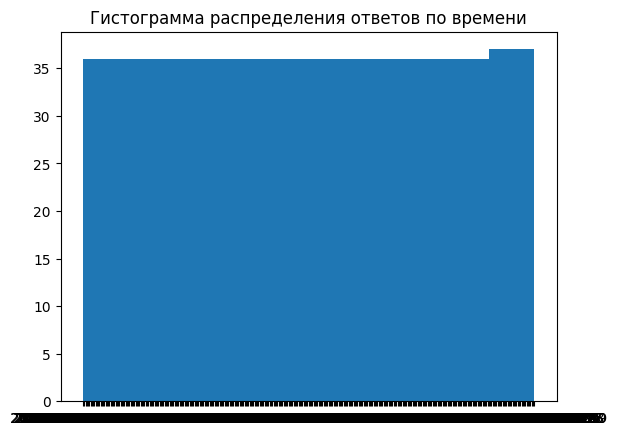

In [55]:
plt.hist(data['timestamp'])
plt.title('Гистограмма распределения ответов по времени')
plt.show()

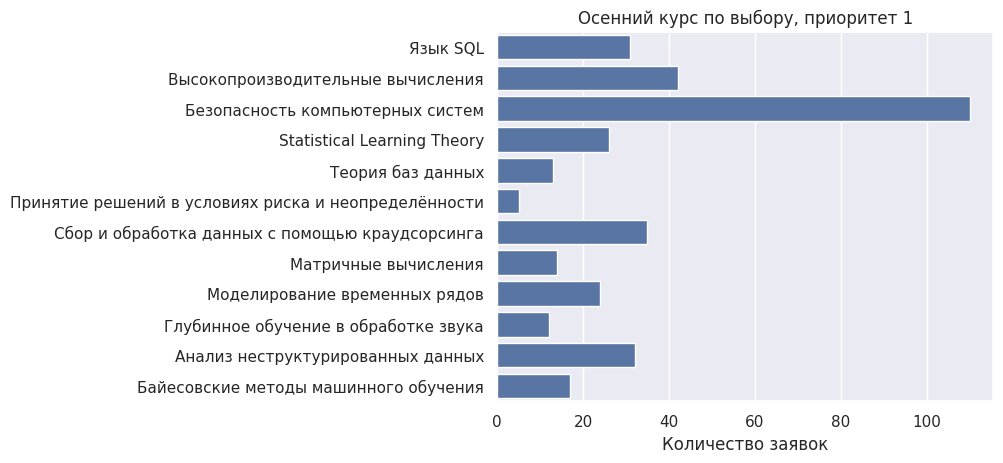

In [56]:
sns.set()

fig, ax = plt.subplots()
ax = sns.countplot(y='fall_1', data=data)
ax.set_title('Осенний курс по выбору, приоритет 1')
ax.set_ylabel('')

ax.set(xlabel='Количество заявок')

plt.show()

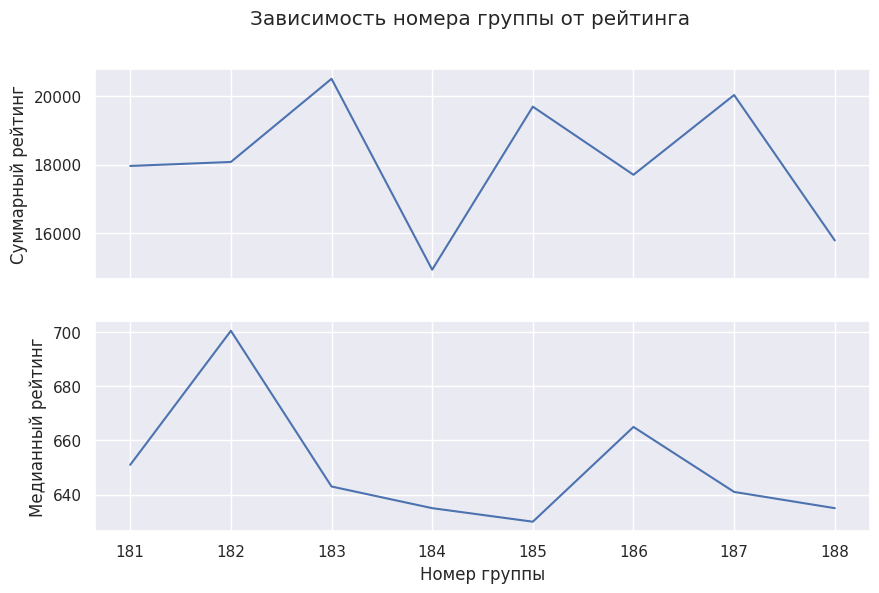

In [57]:
crs3 = data.filter(pl.col("17_group").is_null())
gr_raiting_med = crs3.group_by('18_group').agg(pl.col('rating').median()).sort("18_group")
gr_raiting_sum = crs3.group_by('18_group').agg(pl.col('rating').sum()).sort("18_group")

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Зависимость номера группы от рейтинга')
#fig.text('Рейтинг')


axs[0].plot(gr_raiting_sum["18_group"], gr_raiting_sum["rating"])
axs[0].set_ylabel('Суммарный рейтинг')

axs[1].plot(gr_raiting_med["18_group"], gr_raiting_med["rating"])
axs[1].set_ylabel('Медианный рейтинг')

plt.xlabel('Номер группы')

plt.show()

Если вы будете делать графики без подписанных осей, с налезающими друг на друга метками, неаккуратными линиями и т.д., то имеете все шансы попасть сюда: https://t.me/funny_homeworks

Сохраним полученную таблицу, чтобы вы могли продолжить с ней работу дома:

In [58]:
data.write_csv('end_seminar.csv')

### Разведочный анализ данных

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:
* выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
* выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
* выяснить, нет ли повторов в данных
* выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке: https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

Рассказ во многом взят из ноутбука https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

Загрузим данные и изучим доступные нам признаки.

In [60]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [61]:
train = pl.read_csv('train.csv')
train.head()

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
str,i64,str,str,i64,f64,f64,f64,f64,str,i64
"""id2875421""",2,"""2016-03-14 17:24:55""","""2016-03-14 17:32:30""",1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455
"""id2377394""",1,"""2016-06-12 00:43:35""","""2016-06-12 00:54:38""",1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663
"""id3858529""",2,"""2016-01-19 11:35:24""","""2016-01-19 12:10:48""",1,-73.979027,40.763939,-74.005333,40.710087,"""N""",2124
"""id3504673""",2,"""2016-04-06 19:32:31""","""2016-04-06 19:39:40""",1,-74.01004,40.719971,-74.012268,40.706718,"""N""",429
"""id2181028""",2,"""2016-03-26 13:30:55""","""2016-03-26 13:38:10""",1,-73.973053,40.793209,-73.972923,40.78252,"""N""",435


Смысл столбцов:

* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

In [62]:
train.shape

(1458644, 11)

Данных довольно много, поэтому нужно задумываться об эффективности всех вычислений. Ниже мы увидим на примере, что правильное использование возможностей pandas позволит существенно ускорить вычисления.

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. Например, в голову приходят следующие вопросы:
* можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
* есть ли где-то пропуски?
* действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [63]:
print('Id is unique.') if train.select(pl.col("id").n_unique() == pl.len()).item() else print('oops')

Id is unique.


In [64]:
print('We do not need to worry about missing values.') if train.null_count().sum_horizontal().item() == 0 else print('oops')

We do not need to worry about missing values.


In [65]:
unique_values = train.select(pl.col("store_and_fwd_flag").unique()).to_numpy().ravel()

print('The store_and_fwd_flag has only two values:', unique_values)

The store_and_fwd_flag has only two values: ['Y' 'N']


Посмотрим на типы данных в каждом столбце.

In [66]:
train.schema

Schema([('id', String),
        ('vendor_id', Int64),
        ('pickup_datetime', String),
        ('dropoff_datetime', String),
        ('passenger_count', Int64),
        ('pickup_longitude', Float64),
        ('pickup_latitude', Float64),
        ('dropoff_longitude', Float64),
        ('dropoff_latitude', Float64),
        ('store_and_fwd_flag', String),
        ('trip_duration', Int64)])

Видно, что `polars` отнёс столбцы с датами к общему типу `pl.String`. Будет лучше привести их к типу `pl.DateTime`, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец `check_trip_duration` показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и `dropoff_datetime`.

In [67]:
# помним, что with_columns работает с конкретными состояниями колонок

train = (
    train.with_columns(
        # не забывайте, что если название не меняется, оно берется из первого попавшегося pl.Expr
        pl.col("pickup_datetime").str.to_datetime(),
        pl.col("dropoff_datetime").str.to_datetime(),
        1 * (pl.col("store_and_fwd_flag") == "Y"),
    )
    .with_columns(
        pickup_date=pl.col("pickup_datetime").dt.date(),
        check_trip_duration=(
            pl.col("dropoff_datetime") - pl.col("pickup_datetime")
        ).dt.total_seconds(),
    )
)

# проверим, что у нас все ништяк, мы только что посчитали длину поездки сами, но она в датасете уже есть
duration_difference = train.select(
    (
        (pl.col("check_trip_duration") - pl.col("trip_duration")).abs() > 1
    ).sum()
)

print('Trip_duration and datetimes are ok.') if duration_difference.item() == 0 else print('Ooops.')
train.head(2)

Trip_duration and datetimes are ok.


id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64
"""id2875421""",2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455,0,2016-03-14,455
"""id2377394""",1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663,0,2016-06-12,663


In [68]:
train.schema

Schema([('id', String),
        ('vendor_id', Int64),
        ('pickup_datetime', Datetime(time_unit='us', time_zone=None)),
        ('dropoff_datetime', Datetime(time_unit='us', time_zone=None)),
        ('passenger_count', Int64),
        ('pickup_longitude', Float64),
        ('pickup_latitude', Float64),
        ('dropoff_longitude', Float64),
        ('dropoff_latitude', Float64),
        ('store_and_fwd_flag', String),
        ('trip_duration', Int64),
        ('literal', Int32),
        ('pickup_date', Date),
        ('check_trip_duration', Int64)])

Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

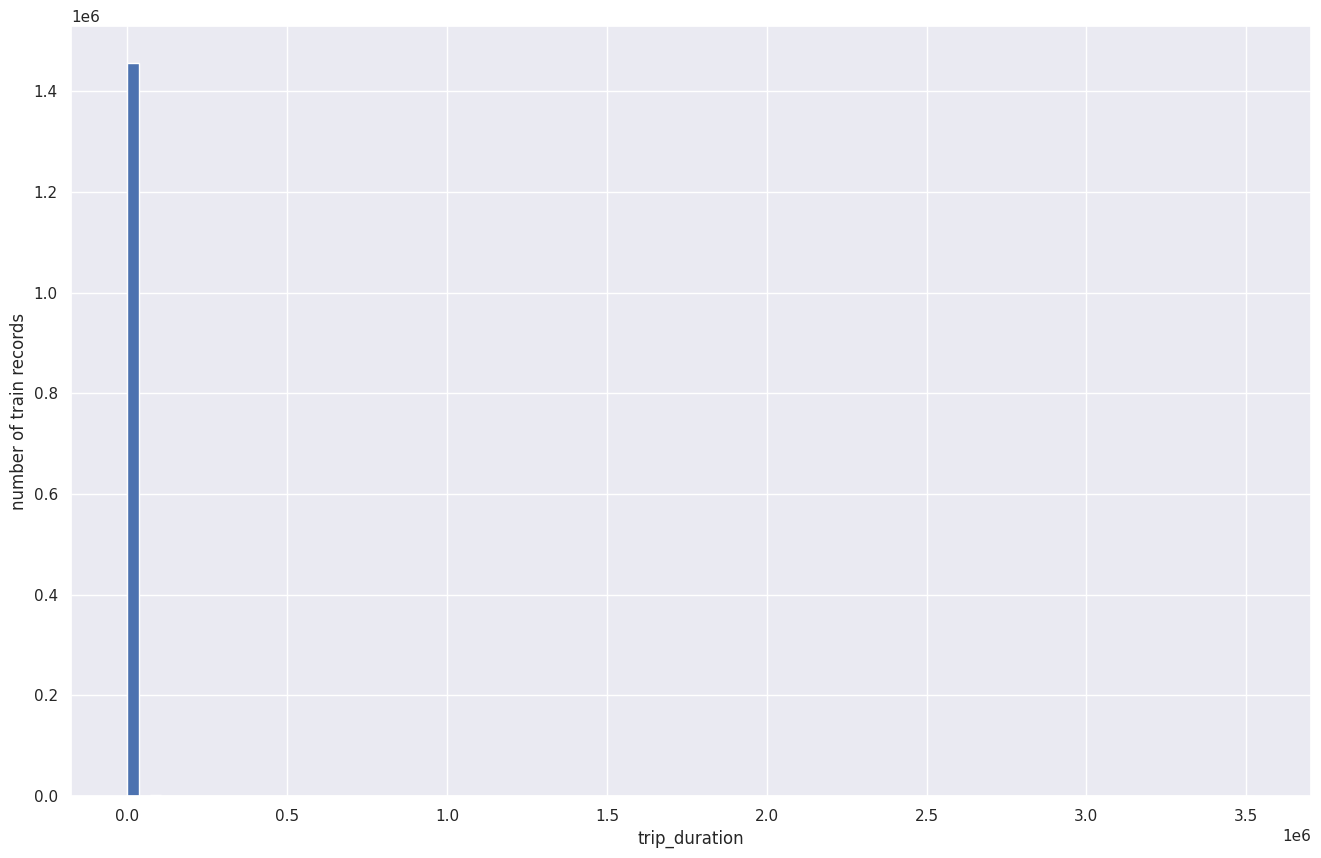

In [69]:
plt.hist(train['trip_duration'].to_numpy(), bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно нарисовать распределение в логарифмической шкале.

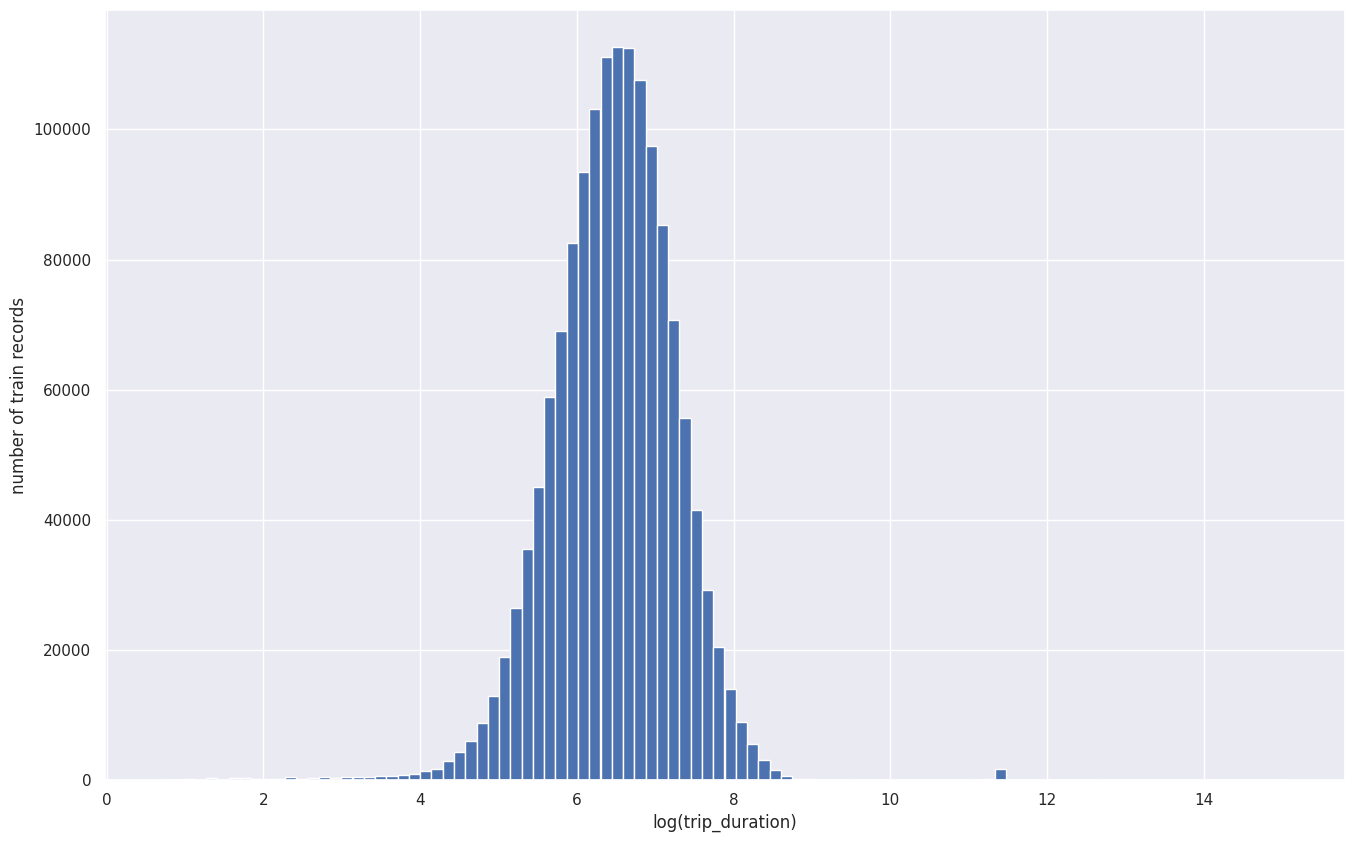

In [70]:
train = train.with_columns(log_trip_duration=pl.col("trip_duration").log1p())
plt.hist(train["log_trip_duration"].to_numpy(), bins=100)
plt.xlabel("log(trip_duration)")
plt.ylabel("number of train records")
plt.show()

Не забудьте, что если мы хотим предсказывать длительность поездки, логарифм длительности это совсем не то же самое, что сама длительность!!!

In [71]:
train.select((pl.col("log_trip_duration").exp() == pl.col("trip_duration")).sum())

log_trip_duration
u32
0


Подумайте самостоятельно, что нужно здесь сделать: $\log{\exp{y}}$, либо ${\exp{\log{y}}}$, либо что-то еще. Вопрос не так прост, как кажется...

В целом распределение разумное, продолжительность поездки находится примерно в следующем интервале:

In [72]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

В секундах: 148.4131591025766 8103.083927575384
В минутах: 2.0 135.0


Самая длинная поездка (в часах):

In [73]:
train['trip_duration'].max() // 3600

979

In [74]:
train.filter(pl.col("trip_duration") >= 979 * 3600)

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration,log_trip_duration
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64,f64
"""id0053347""",1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,"""N""",3526282,0,2016-02-13,3526282,15.075755


Это выброс. Мог сломаться таксометр, водитель мог забыть остановить поездку по каким-то причинам и т.д. В любом случае, будет странно обучаться на таких данных, обычно их выкидывают из выборки. Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч, и определённо надо выяснять, что это такое.

In [75]:
train.filter(pl.col("trip_duration") >= 10 * 3600)

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration,log_trip_duration
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64,f64
"""id3307903""",2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,"""N""",84594,0,2016-02-20,84594,11.34563
"""id1091477""",2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.97628,40.750889,"""N""",86149,0,2016-05-07,86149,11.363845
"""id3431345""",2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,"""N""",86352,0,2016-06-07,86352,11.366199
"""id1487069""",2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.96859,40.799217,-73.979584,40.784714,"""N""",86236,0,2016-02-13,86236,11.364855
"""id3674870""",2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.98909,40.736992,-73.972336,40.751511,"""N""",85197,0,2016-03-18,85197,11.352733
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""id2798196""",2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,"""N""",72504,0,2016-03-20,72504,11.191411
"""id2055880""",2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.76421,"""N""",86233,0,2016-02-08,86233,11.36482
"""id1910950""",2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,"""N""",85311,0,2016-06-08,85311,11.35407


Попробуем нарисовать, откуда обычно стартуют поездки.

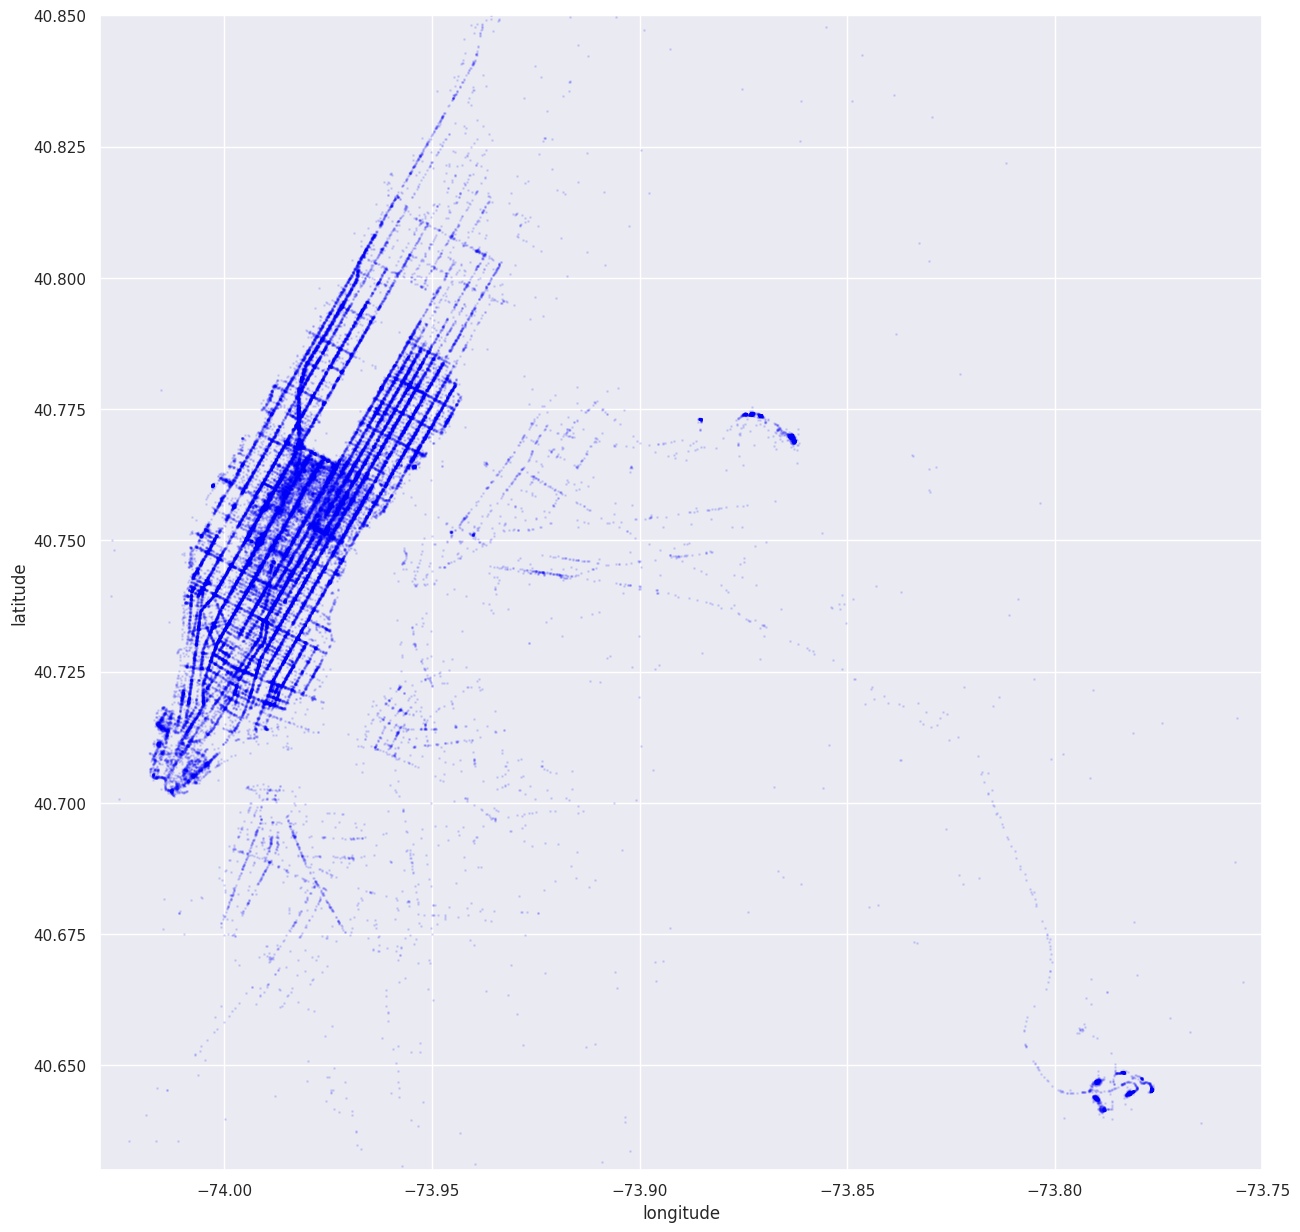

In [76]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15, 15))
plt.scatter(
    train["pickup_longitude"].to_numpy()[:N],
    train["pickup_latitude"].to_numpy()[:N],
    color="blue",
    s=1,
    label="train",
    alpha=0.1,
)
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Теперь нарисуем как следует, на карте.

In [77]:
!pip install -qU ipyleaflet

In [78]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [79]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    # поскольку поларс это кортеж кортежей, если хотим обращаться по ключам, нужен дикт
    for row in data.rows(named=True):
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[40.75195151901245, -73.9720171585083], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Кстати, случайный ли порядок записей в таблице? Это важно понимать, например, для разбиения выборки на обучающую и тестовую части. Если порядок не является случайным, а мы отнесём к обучающей части первую половину таблицы, то есть риск, что данные в обучении и тесте будут иметь разные распределения, а значит, модель сможет хорошо работать только на одной из частей.

Text(0, 0.5, 'Дней с момента ранней поездки')

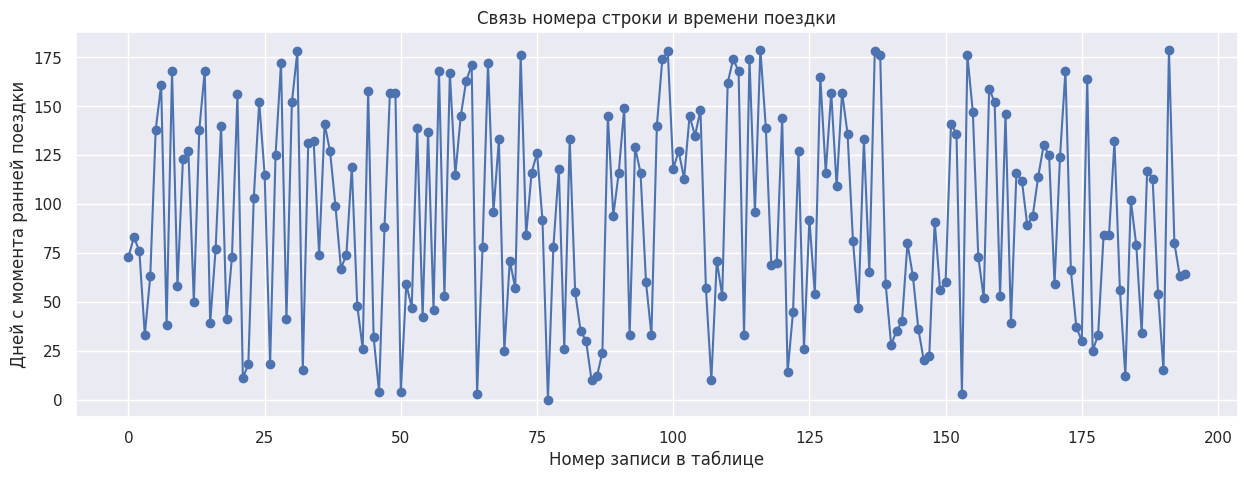

In [80]:
plt.figure(figsize=(15, 5))

days_since_min_ride = train.select(
    (pl.col("pickup_datetime") - pl.col("pickup_datetime").min()).dt.total_seconds()
    // (60 * 60 * 24)
)

plt.plot(days_since_min_ride[::7500], "o-")
plt.title("Связь номера строки и времени поездки")
plt.xlabel("Номер записи в таблице")
plt.ylabel("Дней с момента ранней поездки")

Вроде бы всё довольно случайно, по крайней мере ничего непонятно...

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его. Кстати, важно заметить, что само расстояние не может быть признаком, поскольку в тестовой выборке нет информации о пункте назначения. Но мы пока исследуем данные и, может, увидим в расстояниях что-то интересное.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula).

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт [манхэттенское расстояние](https://en.wikipedia.org/wiki/Taxicab_geometry) — оно учитывает, что машины всё-таки не летают.

Здесь же очень удобно будет взглянуть на то, как работает аналог `apply` в пандасе. В поларсе есть несколько функций для этого - `map_elements`, `map_batches` и другие. Часть работает с элементами, часть со всей строкой. Подробнее можете ознакомиться в документации. Если вам лень считать именно поларсовскими силами, можете воспользоваться этими функциями, но как и всегда, предупреждаем, что эти операции не оптимизированы и зачастую работают дольше, чем можно подумать

In [81]:
import numpy as np

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [82]:
train = train.with_columns(
    distance_haversine=pl.struct(
        "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"
    ).map_elements(
        lambda x: haversine_array(
            x["pickup_latitude"],
            x["pickup_longitude"],
            x["dropoff_latitude"],
            x["dropoff_longitude"],
        ),
        return_dtype=float,
    ),
    distance_dummy_manhattan=pl.struct(
        "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"
    ).map_elements(
        lambda x: dummy_manhattan_distance(
            x["pickup_latitude"],
            x["pickup_longitude"],
            x["dropoff_latitude"],
            x["dropoff_longitude"],
        ),
        return_dtype=float,
    ),
)

train.head(2)

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration,log_trip_duration,distance_haversine,distance_dummy_manhattan
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64,f64,f64,f64
"""id2875421""",2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455,0,2016-03-14,455,6.122493,1.498521,1.735433
"""id2377394""",1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663,0,2016-06-12,663,6.498282,1.805507,2.430506


Обсудим немного скорость вычислений в polars. Есть несколько способов применить функцию к каждой строке в таблице. Если вы до этого изучали преимущественно C/C++, то первое, что должно прийти вам в голову, — написать цикл.

In [83]:
train1 = train.clone()

In [84]:
%%timeit

for i in range(100):
    train1[i, 'distance_haversine'] = haversine_array(*train[i, ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]])

713 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Обратите внимание, что мы посчитали расстояния всего лишь для первых 100 записей, и это уже было не очень быстро.

Можно воспользоваться функцией `map_elements`.

In [85]:
%%timeit

# для сравнение - в пандасе apply позволяет за то же время прогнать 5к записей
train[:35000].with_columns(
    distance_haversine=pl.struct(
        "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"
    ).map_elements(
        lambda x: haversine_array(
            x["pickup_latitude"],
            x["pickup_longitude"],
            x["dropoff_latitude"],
            x["dropoff_longitude"],
        ),
        return_dtype=float,
    ),
)

601 ms ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


За то же самое время мы успеваем обработать уже 35000 записей, а не 100.

Еще быстрее можно сделать, если распараллелить, что в поларсе делается из коробки. Применим `map_batches`, там немножко другой синтаксис

In [86]:
%%timeit

# а тут пандас даже не близко
train.with_columns(
    distance_haversine=pl.struct(
        "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"
    ).map_batches(
        lambda x: haversine_array(
            x.struct.field("pickup_latitude"),
            x.struct.field("pickup_longitude"),
            x.struct.field("dropoff_latitude"),
            x.struct.field("dropoff_longitude"),
        ),
        return_dtype=float,
    ),
)

225 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Смогли прогнать все 1.5кк записей еще быстрее

Но лучший способ — это векторизовать вычисления. Подробнее об этом мы будем говорить на следующих семинарах и в дз

In [87]:
%%timeit

# все еще в 5 раз быстрее, чем в векторизованном пандасе
(
    train
    .with_columns(
        lat=pl.col("dropoff_latitude").radians() - pl.col("pickup_latitude").radians(),
        lon=pl.col("dropoff_longitude").radians() - pl.col("pickup_longitude").radians(),
    )
    .with_columns(
        d=(
            (pl.col("lat") * 0.5).sin() ** 2
            + pl.col("pickup_latitude").radians().cos()
            * pl.col("dropoff_latitude").radians().cos()
            * (pl.col("lon") * 0.5).sin() ** 2
        ),
    )
    .with_columns(haversine_distance=2 * 6371 * pl.col("d").sqrt().arcsin())
)

93.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Посмотрим на распределения расстояний.

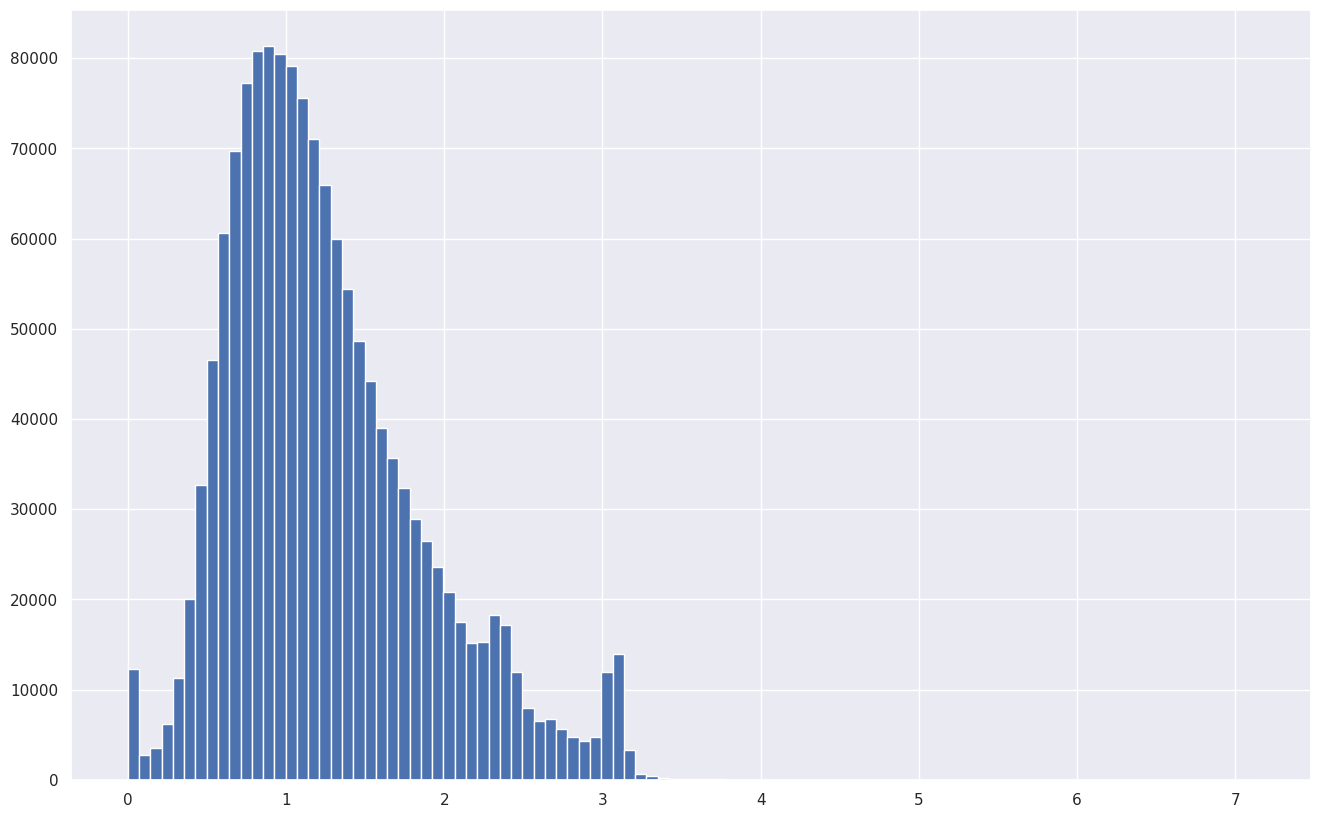

In [88]:
plt.hist(np.log1p(train["distance_haversine"]), bins=100)
plt.show()

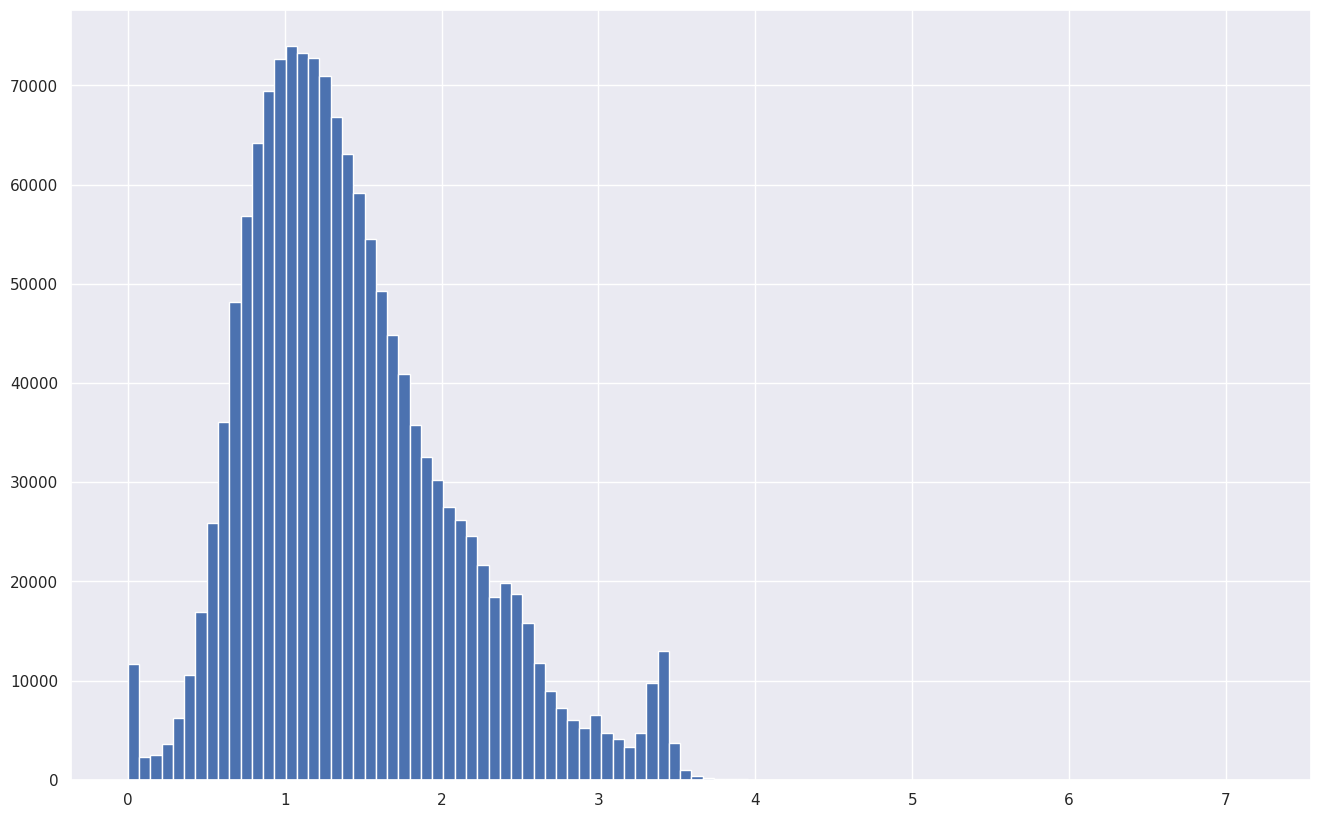

In [89]:
plt.hist(np.log1p(train["distance_dummy_manhattan"]), bins=100)
plt.show()

Выглядят достаточно одинаково.

Поисследуем теперь связь между расстоянием и продолжительностью поездки.

Text(0, 0.5, 'trip duration')

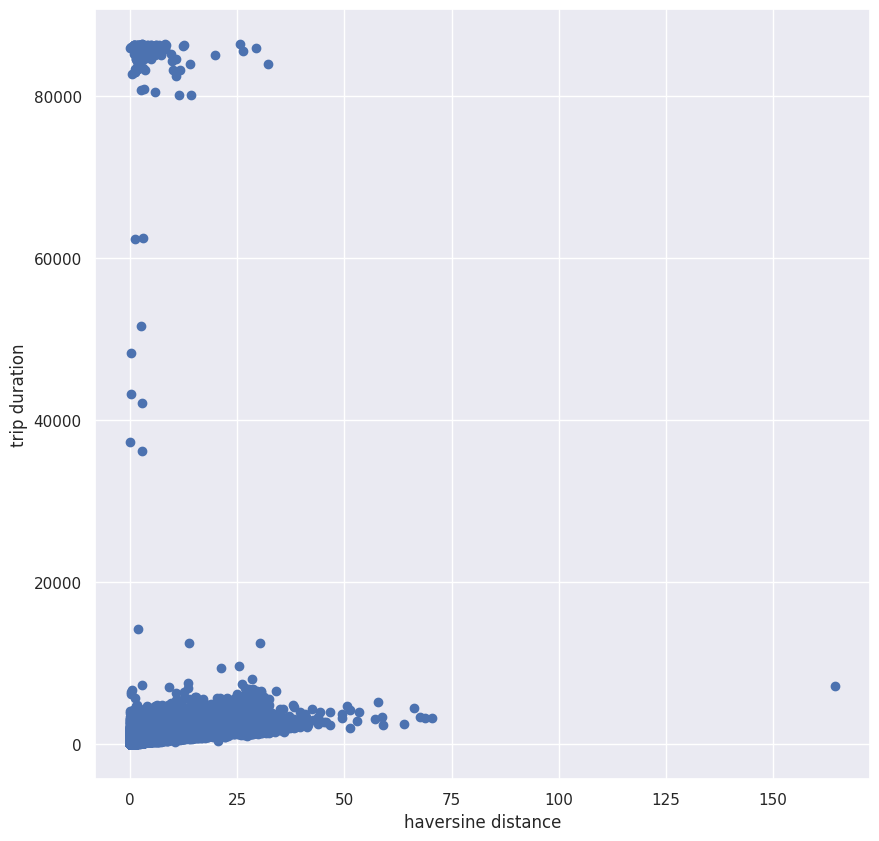

In [90]:
plt.figure(figsize=(10,10))
plt.scatter(train["distance_dummy_manhattan"][:100000], train["trip_duration"][:100000], marker='o')
plt.xlabel('haversine distance')
plt.ylabel('trip duration')

В нижней части графика точки неплохо выстраиваются в линию, но ещё есть некоторое количество выбросов. Нарисуем тот же график без них.

Text(0, 0.5, 'trip duration')

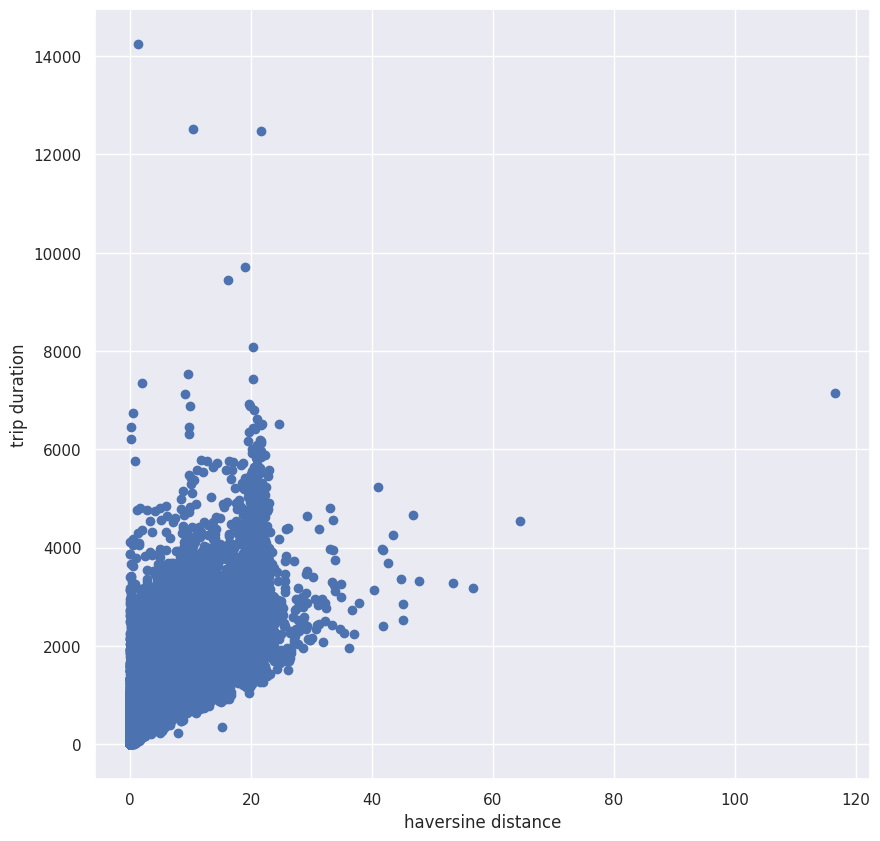

In [91]:
plt.figure(figsize=(10, 10))
plt.scatter(
    train.filter(pl.col("trip_duration") < 20000)["distance_haversine"][:100000],
    train.filter(pl.col("trip_duration") < 20000)["trip_duration"][:100000],
    marker="o",
)
plt.xlabel("haversine distance")
plt.ylabel("trip duration")

Кажется, тут вполне может сработать линейная регрессия!

Ещё раз напомним, что расстояние не может быть признаком, его не посчитать для тестовой выборки. Но мы пока просто играемся.

In [92]:
from sklearn import linear_model, metrics

In [93]:
train_filtered = train.filter(pl.col("trip_duration") < 20000)
X = train_filtered["distance_haversine"].to_numpy()[:, np.newaxis]
y = train_filtered["trip_duration"].to_numpy()

regr = linear_model.Ridge()
regr.fit(X, y)
metrics.mean_absolute_error(regr.predict(X), y)

299.6592180339746

In [94]:
train_filtered = train.filter(pl.col("trip_duration") < 20000)
X = train_filtered["distance_dummy_manhattan"].to_numpy()[:, np.newaxis]
y = train_filtered["trip_duration"].to_numpy()

regr = linear_model.Ridge()
regr.fit(X, y)
metrics.mean_absolute_error(regr.predict(X), y)

306.0326596057464

То есть в среднем модель ошибается где-то на 300 секунд при предсказании продолжительности поездки. Как понять, хорошо это или плохо? Например, сравнить с качеством константной модели — например, которая всегда в качестве прогноза выдаёт медианное или среднее время поездки.

In [95]:
metrics.mean_absolute_error(np.median(y) * np.ones(y.shape), y)

444.8109724449668

In [96]:
metrics.mean_absolute_error(np.mean(y) * np.ones(y.shape), y)

468.0349997665766

### Почему важно исследовать данные?

Иногда бывает, что задача сложная, но при этом хорошего качества можно добиться с помощью простых правил. Причины могут быть разные:
* Разметка собрана по простому правилу. Например, для задачи предсказания тональности твитов могли сделать разметку через эмодзи — тогда достаточно, скажем, добавить признак "наличие в тексте подстроки ':)'".
* Задача действительно простая и не требует поиска закономерностей методами машинного обучения.
* В данных есть утечка (leak) — то есть в признаках содержится информация, которая на самом деле не должна быть доступна при построении прогноза.

Про некоторые истории с утечками можно почитать и посмотреть здесь:
* https://dyakonov.org/2018/06/28/простые-методы-анализа-данных/
* https://www.kaggle.com/c/the-icml-2013-whale-challenge-right-whale-redux/discussion/4865
* https://www.youtube.com/watch?v=UOxf2P9WnK8

### Еще пара приколюх

Мы уже достаточно плотно исседовали всевозможные интересности поларса, но этим все не исчерпывается. Если вам когда-либо хотелось использовать оконные функции, подобно SQL, в пандасе, но вы всегда стеснялись, то теперь вам больше не придется скрывать свои извращенные фантазии. В поларсе инструментарий оконок такой же, и даже больше, тогда как в пандасе они есть в очень и очень ограниченном виде. Рассмотрим пример

Допустим, мы хотим рассчитать среднее расстояние, в зависимости от числа пассажиров. В пандасе, пожалуй, самый действенный способ это сделать групбай, а затем приджойнить то, что вам нужно. В поларсе это делается одной строкой (но длинной)

In [97]:
(
    train
    .with_columns(
        distance_per_passenger_count=(
            pl.col("distance_haversine")
            .median()
            .over("passenger_count")
        )
    )
    .head(3)
)

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration,log_trip_duration,distance_haversine,distance_dummy_manhattan,distance_per_passenger_count
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64,f64,f64,f64,f64
"""id2875421""",2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455,0,2016-03-14,455,6.122493,1.498521,1.735433,2.073359
"""id2377394""",1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663,0,2016-06-12,663,6.498282,1.805507,2.430506,2.073359
"""id3858529""",2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,"""N""",2124,0,2016-01-19,2124,7.661527,6.385098,8.203575,2.073359


Разумеется, выражение может быть куда как круче. Тут работает та же логика, что и с остальными `pl.Expr` - при желании можно творить совсем уж адовые трансформации

In [98]:
(
    train.with_columns(
        something_very_strange=(
            pl.col("distance_haversine") * pl.col("distance_dummy_manhattan")
        )
        .map_elements(lambda x: x > 1) # можно и без апплая, чисто показываем, что кастомные оконки тоже можно
        .over("passenger_count", "vendor_id")
    ).head(3)
)

/tmp/ipython-input-1301141686.py:6: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("distance_haversine").map_elements(lambda x: ...)
with this one instead:
  + pl.col("distance_haversine") > 1

  .map_elements(lambda x: x > 1) # можно и без апплая, чисто показываем, что кастомные оконки тоже можно


id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,literal,pickup_date,check_trip_duration,log_trip_duration,distance_haversine,distance_dummy_manhattan,something_very_strange
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64,i32,date,i64,f64,f64,f64,bool
"""id2875421""",2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455,0,2016-03-14,455,6.122493,1.498521,1.735433,true
"""id2377394""",1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663,0,2016-06-12,663,6.498282,1.805507,2.430506,true
"""id3858529""",2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,"""N""",2124,0,2016-01-19,2124,7.661527,6.385098,8.203575,true


На примерах выше мы уже убедились, что поларс очень часто оказывается эффективнее пандаса по времени. Эффективнее он будет и по памяти - одни и те же данные в поларсе и в пандасе будут отличаться по размеру занимаемой памяти, можете убедиться в этом сами, поларс хранит данные эффективнее.

Но, пожалуй, самая главная фишка поларс - ленивые вычисления. Идея заключается в том, чтобы преобразовывать данные именно тогда, когда это требуется, делать это батчами, и параллелить. Таким образом можно обрабатывать даже те данные, которые в память не влезают. Давайте еще разок взглянем на датасет со студентиками

In [99]:
# читаем датафрейм
initial_df = pl.read_csv("end_seminar.csv")
print(initial_df.shape[0], "rows")
print(initial_df.estimated_size("mb"), "mb")

361 rows
0.1487264633178711 mb


Как видим, он достаточно маленький. С такими объёмами выбор библиотеки это чисто вкусовщина. Давайте немного поднимем ставки

In [100]:
def repeat_df(df: pl.DataFrame | pl.LazyFrame, n: int = 2) -> pl.LazyFrame:
    return (
        df.lazy()
        .select(pl.col("timestamp").unique().sort().repeat_by(n).flatten())
        .join(df.lazy(), on="timestamp", how="left")
    )

Для работы с датафреймами, которые в память не влезают, нам понадобится объект `pl.LazyFrame`. Он представляет из себя схему выполнения вашего запроса, который оптимизируется, бьётся на батчи и параллелится под капотом через StreamingAPI, что для нас просто идеально. Перевести объект туда можно через метод `lazy`, обратно через `collect`. Учтите, что `streaming=True` работает не со всеми операциями, применяйте с умом, это можно проверить через `pl.LazyFrame.explain(streaming=True)`

In [101]:
repeat_n = 2

repeated_df = repeat_df(initial_df, repeat_n)
print("Schema")
print(repeated_df.explain(streaming=True, optimized=True))

Schema
LEFT JOIN:
LEFT PLAN ON: [col("timestamp")]
  SELECT [col("timestamp").unique().sort(asc).repeat_by([dyn int: 2]).explode()]
    DF ["timestamp", "id", "rating", "18_group", ...]; PROJECT["timestamp"] 1/17 COLUMNS
RIGHT PLAN ON: [col("timestamp")]
  DF ["timestamp", "id", "rating", "18_group", ...]; PROJECT */17 COLUMNS
END LEFT JOIN


/tmp/ipython-input-2973500786.py:5: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  print(repeated_df.explain(streaming=True, optimized=True))


In [102]:
# как видим, повторы работают
repeated_df = repeated_df.collect()
assert repeated_df.shape[0] == initial_df.shape[0] * repeat_n
print(repeated_df.shape[0], "rows")
print(repeated_df.estimated_size("mb"), "mb")

722 rows
0.29738521575927734 mb


Теперь ещё интереснее. Если бы наш датасет был не в 2 раза больше, а в 100000 раз, что бы мы делали? К счастью для нас, поларс может уместить 300кк строк всего лишь в 512Мб, и это даже не прикол, но работать с этим придётся немного иначе

In [103]:
N = 100000

df = repeat_df(initial_df, N)
print(initial_df.estimated_size("gb") * N, "gb")

14.524068683385849 gb


Поэтому даже такая тривиальная задача, как подсчёт строк становится уже не такой простой. Про это будет наше первое домашнее задание, где вы сможете поупражняться в использовании `pl.LazyFrame`

In [104]:
try:
    print(df.shape[0], "rows")
except AttributeError:
    print("ой, не получилось...")

# df.collect().shape[0] # тоже можно, если влезет, никаких вычислений там не производится
# len(df.collect().to_pandas()) # а такое может крашнуть ядро, попробуйте, хехе...

ой, не получилось...


In [105]:
def lazy_len(df: pl.LazyFrame) -> int:
    return df.select(pl.len()).collect().item()


rows = lazy_len(df)  # намного экономнее, потому что оптимизировано под капотом
assert rows == initial_df.shape[0] * N
print(rows, "rows")

36100000 rows


Список операций, которые работают с `pl.LazyFrame` достаточно большой, можно ознакомиться с ними вот [здесь](https://docs.pola.rs/api/python/stable/reference/lazyframe/index.html). Посмотрим еще на парочку методов и будем закругляться

In [106]:
type(df)

polars.lazyframe.frame.LazyFrame

In [107]:
df.select(pl.col("is_mi").mean()).collect()

is_mi
f64
1.0


In [108]:
df.group_by("is_mi").agg(pl.col("fall_1").mode()).collect()

is_mi,fall_1
i64,list[str]
1,"[""Моделирование временных рядов""]"
null,"[""Безопасность компьютерных систем""]"


In [109]:
df.filter(pl.col("rating") == pl.col("rating").min()).unique().collect(streaming=True)

/tmp/ipython-input-460804063.py:1: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  df.filter(pl.col("rating") == pl.col("rating").min()).unique().collect(streaming=True)


timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,strange_column,percentile,17_group,blended,is_ml_student
str,str,f64,i64,i64,str,str,str,str,str,str,str,f64,f64,str,str,bool
"""2020-05-20 11:34:10""","""7a21ef645ecb42198be493dd65320e…",495.0,188,null,"""Принятие решений в условиях ри…","""Язык SQL""","""Сбор и обработка данных с помо…","""Анализ данных в бизнесе""","""Промышленное программирование …","""Дополнительные главы прикладно…","""Да""",245213.0,0.995516,null,null,null


Как видно, работает и впрямь многое. Если же пытаться сделать это на большом датафрейме без использования `pl.LazyFrame`, результат будет далеко не такой веселый. Поэтому будьте крайне нежны и аккуратны, если ваши данные слишком уж большие